In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

0.010005725716948615


<ErrorbarContainer object of 3 artists>

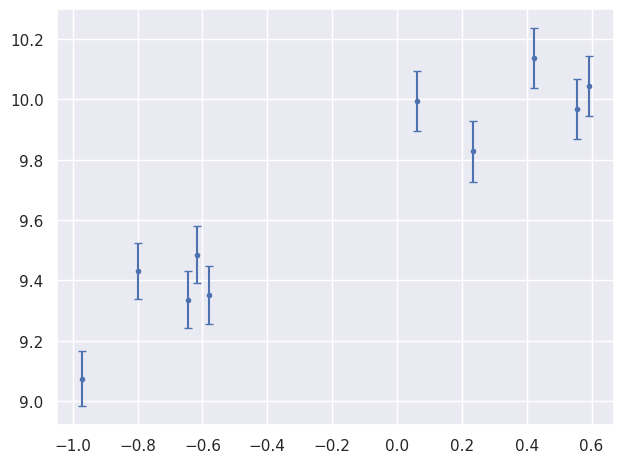

In [101]:
real_argmax = 0.4
real_max = 10
real_curvature = - 0.5
relative_error = 0.01

xx = np.random.uniform(-1,1, size=10)
yy = real_max+real_curvature*(xx-real_argmax)**2 
ss = relative_error*yy

yy += yy*np.random.normal(0, relative_error, size=len(xx))

print(np.mean(ss/yy))

plt.errorbar(xx, yy, ss,ls="", marker=".")

In [120]:
import emcee

def log_prior(theta):
    a, b, c = theta
    if -5.0 < a < 0 and 5.0 < b < 15.0 and -3.0 < c < 10:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y, yerr):
    a, b, c = theta
    model = a*(x-c)**2 + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos =  np.random.normal(0,1, size=(32, 3))
pos[:, 0] = np.random.normal(real_curvature, 0.2, size=32)
pos[:, 1] = np.random.normal(real_max, 0.2, size=32)
pos[:, 2] = np.random.normal(real_argmax, 0.3, size=32)

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(xx, yy, ss))
sampler.run_mcmc(pos, 20000, progress=True);

You must install the tqdm library to use progress indicators with emcee


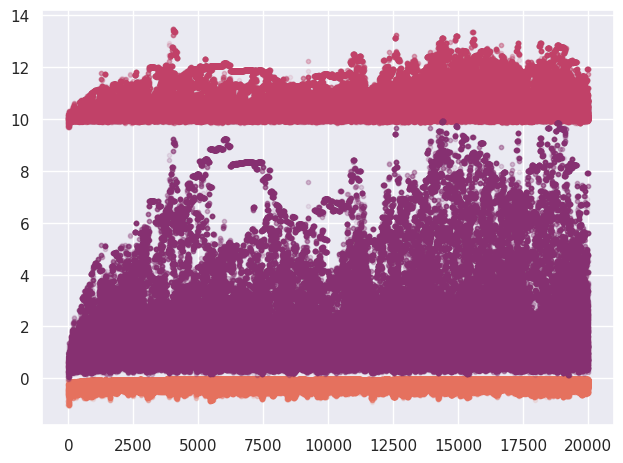

In [121]:
import seaborn as sns
sns.set()
samples = sampler.get_chain()

colors = sns.color_palette("flare", 3)
for i in range(ndim):
    plt.plot(samples[:,:,i], color=colors[i], alpha=0.1, ls="", marker=".")


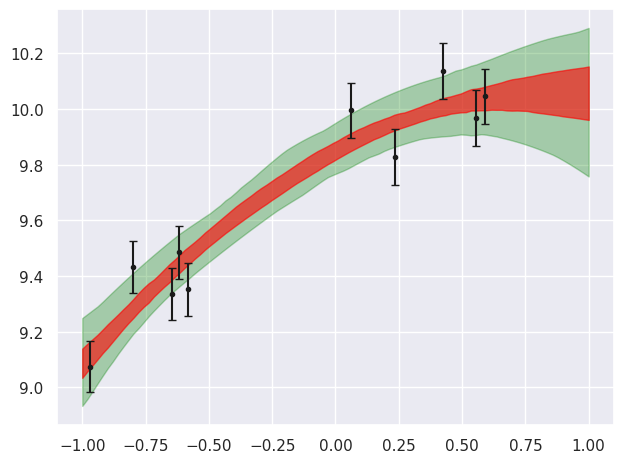

In [122]:
x_hat = np.linspace(-1,1, 100)
models_matrix = np.zeros((800,100))
for i in range(800):
    a,b,c = samples[i+100, 0, :]
    models_matrix[i] = model = a*(x_hat-c)**2 + b
    # plt.plot(x_hat, models_matrix[i], alpha=0.01, color="k")
plt.errorbar(xx, yy,ss, marker=".", ls="",zorder=3, color="k")
plt.fill_between(x_hat, *np.quantile(models_matrix, [0.01, 0.99], axis=0), color="green", alpha=0.3)
plt.fill_between(x_hat, *np.quantile(models_matrix, [0.25, 0.75], axis=0), color="red", alpha=0.6)

In [123]:
bayes_curvature = dict(name="b_curvature", mean=np.mean(samples[:,:,0].reshape(-1)), error=np.std(samples[:,:,0].reshape(-1)), true=real_curvature)
bayes_argmax = dict(name="b_argmax", mean=np.mean(samples[:,:,2].reshape(-1)), error=np.std(samples[:,:,2].reshape(-1)), true=real_argmax)
bayes_max = dict(name="b_max", mean=np.mean(samples[:,:,1].reshape(-1)), error=np.std(samples[:,:,1].reshape(-1)), true=real_max)

Text(10, 1, 'max\n10.36 +- 0.49')

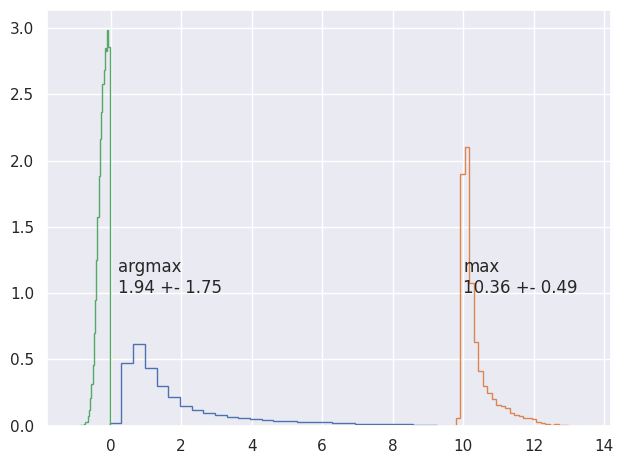

In [124]:
plt.hist(samples[:,:,2].reshape(-1), histtype="step", bins=30, density=True);
plt.hist(samples[:,:,1].reshape(-1), histtype="step", bins=30, density=True);
plt.hist(samples[:,:,0].reshape(-1), histtype="step", bins=30, density=True);


plt.annotate(f"argmax\n{np.mean(samples[:,:,2].reshape(-1)):.2f} +- {np.std(samples[:,:,2].reshape(-1)):.2f}", (0.2, 1))
plt.annotate(f"max\n{np.mean(samples[:,:,1].reshape(-1)):.2f} +- {np.std(samples[:,:,1].reshape(-1)):.2f}", (10, 1))

## Curve_fit way


param 0 = -0.27849647029915725 +- 0.1959140858820895
param 1 = 10.069598128499244 +- 0.16923811877940537
param 2 = 0.8841815601014855 +- 0.745294442745928


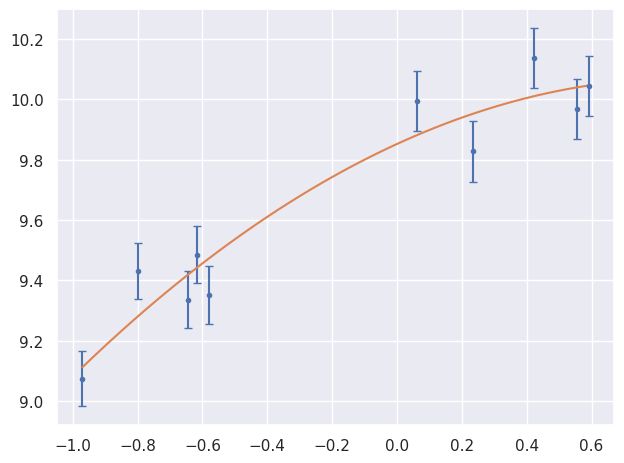

In [125]:
from scipy.optimize import curve_fit

def model(x, a,b,c):
    return a*(x-c)**2 + b

popt, pars = curve_fit(model, xx, yy, sigma=ss)

dummy_x = np.linspace(min(xx), max(xx))
plt.errorbar(xx,yy,ss, ls="", marker=".")
plt.plot(dummy_x, model(dummy_x, *popt))

for i, (par, err) in enumerate(zip(popt, np.sqrt(pars.diagonal()))):
    print(f"param {i} = {par} +- {err}")

In [126]:
orto_curv, orto_argmax, orto_max = dict(name="o_curv"), dict(name="o_argmax"), dict(name="o_max")
orto_curv["mean"], orto_curv["error"], orto_curv["true"] = popt[0], np.sqrt(pars.diagonal())[0], real_curvature
orto_argmax["mean"], orto_argmax["error"], orto_argmax["true"] = popt[2], np.sqrt(pars.diagonal())[2], real_argmax
orto_max["mean"], orto_max["error"], orto_max["true"] = popt[1], np.sqrt(pars.diagonal())[1], real_max

In [127]:
for par in [orto_max,bayes_max, orto_argmax,bayes_argmax, orto_curv, bayes_curvature]:
    print(f"{par['name']:15} = {par['mean']:8.2f} +- {par['error']:8.2f} ({ (par['mean']-par['true'])/par['error'] :4.1f} error bars off) ({ np.abs(par['error']/par['mean'])*100:4.1f} %error)")

o_max           =    10.07 +-     0.17 ( 0.4 error bars off) ( 1.7 %error)
b_max           =    10.36 +-     0.49 ( 0.7 error bars off) ( 4.8 %error)
o_argmax        =     0.88 +-     0.75 ( 0.6 error bars off) (84.3 %error)
b_argmax        =     1.94 +-     1.75 ( 0.9 error bars off) (90.3 %error)
o_curv          =    -0.28 +-     0.20 ( 1.1 error bars off) (70.3 %error)
b_curvature     =    -0.22 +-     0.13 ( 2.1 error bars off) (59.7 %error)


In [128]:
print(real_curvature)
print(real_argmax)
print(real_max)

-0.5
0.4
10
